# Оптимизация обработки стали


Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.


Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).


Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.


Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

***План работы***

1. Первичный анализ данных
2. Предобработка данных, подготовка признаков
3. Машинное обучение
4. Тестирование выбранной модели
5. Вывод

## Первичный анализ данных

### Загрузка данных

In [1]:
%pip install phik
%pip install optuna

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.preprocessing import (
    StandardScaler
)
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import optuna

In [3]:
RANDOM_STATE = 22052023

In [4]:
# Загружаем данные
try:
    arc = pd.read_csv('data_arc_new.csv')
    bulk = pd.read_csv('data_bulk_new.csv')
    bulk_time = pd.read_csv('data_bulk_time_new.csv')
    gas = pd.read_csv('data_gas_new.csv')
    temp = pd.read_csv('data_temp_new.csv')
    wire = pd.read_csv('data_wire_new.csv')
    wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    arc = pd.read_csv('/datasets/data_arc_new.csv')
    bulk = pd.read_csv('/datasets/data_bulk_new.csv')
    bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    gas = pd.read_csv('/datasets/data_gas_new.csv')
    temp = pd.read_csv('/datasets/data_temp_new.csv')
    wire = pd.read_csv('/datasets/data_wire_new.csv')
    wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

Для вывода основной информации о датасетах создадим функцию:

In [5]:
def data_info(data):
    data.info()
    display(data.head(5), data.describe())

### Данные об электродах

In [6]:
data_info(arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


В столбце Реактивная мощность минимальное значение отрицательное, теоретически такое может быть, но не в нашем случае, проверим, сколько еще отрицательных значений существует

In [7]:
print('Количество отрицательных значений в столбце "Реактивная мощность": ',
      arc.loc[arc['Реактивная мощность'] < 0]['key'].count())

Количество отрицательных значений в столбце "Реактивная мощность":  1


Построим гистограмму и диаграмму рассеяния значений без учета аномального значения

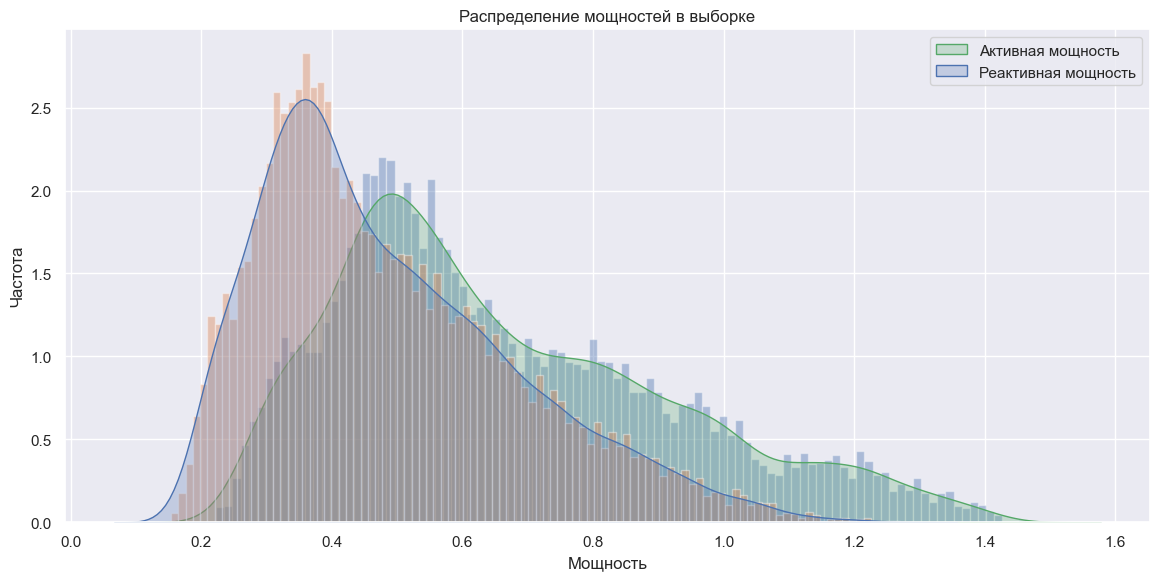

In [8]:
sns.set(rc={'figure.figsize':(14,6.4)})
sns.distplot(arc['Активная мощность'], kde_kws={'shade':True, 'color':'g'}, bins=100)
sns.distplot(arc.loc[arc['Реактивная мощность'] > 0]['Реактивная мощность'], kde_kws={'shade':True, 'color':'b'}, bins=100)
plt.legend(['Активная мощность','Реактивная мощность'])
plt.title('Распределение мощностей в выборке')
plt.xlabel('Мощность')
plt.ylabel('Частота');


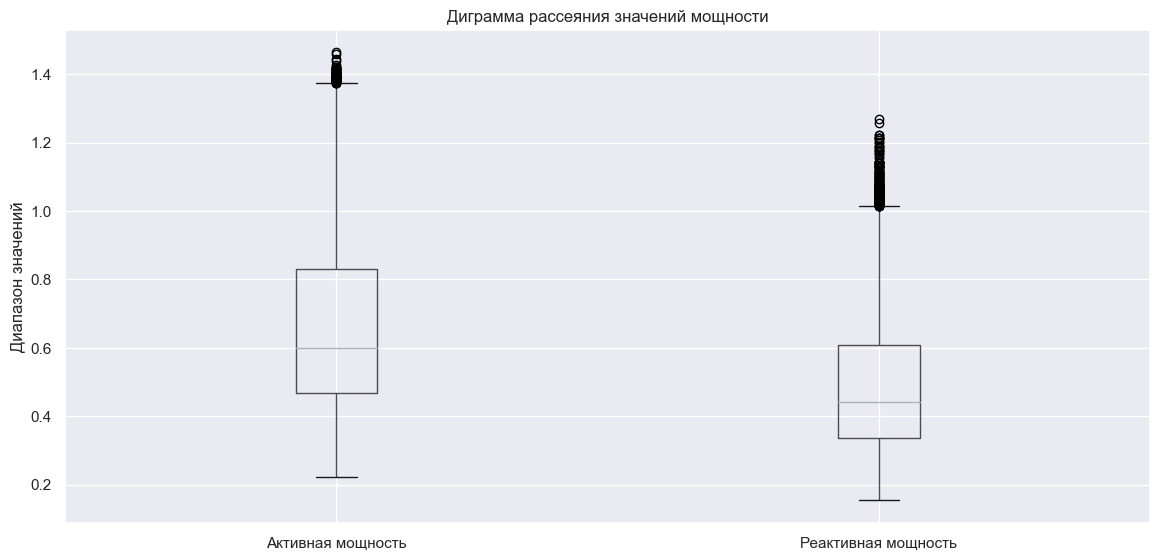

In [9]:
arc.loc[arc['Реактивная мощность'] > 0].drop('key', axis=1).boxplot()
plt.title('Диграмма рассеяния значений мощности')
plt.ylabel('Диапазон значений');

Пропуски в данном датасете отсутствуют, данные в столбцах с временем необходимо привести к типу datetime, данные в столбцах с мощностью имеют нормальное распределение с положительным хвостом, обнаружено аномальное значение в столбце 'Реактивная мощность'

### Данные о подаче сыпучих материалов (объём, время)

In [10]:
print('_______________Объем_______________\n')
data_info(bulk)
print('_______________Время_______________\n')
data_info(bulk_time)

_______________Объем_______________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


_______________Время_______________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Проверим, совпадают ли пропуски в датасетах

In [11]:
pd.DataFrame((bulk.isna() == bulk_time.isna()).mean() == 1, columns=[['Полное совпадение пропусков']]).T

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
Полное совпадение пропусков,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


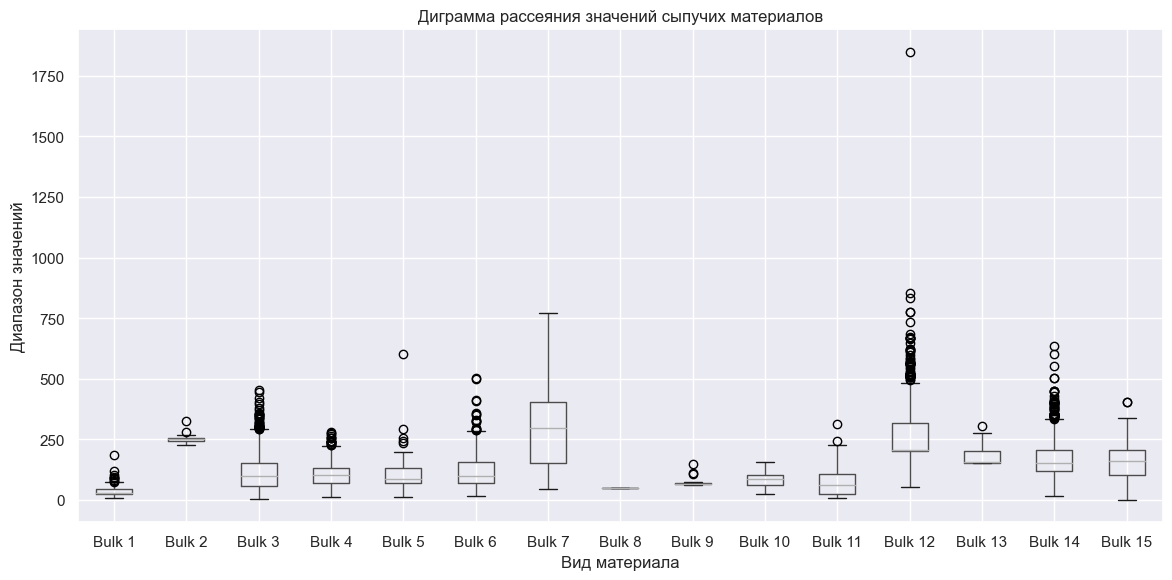

In [12]:
bulk.drop('key', axis=1).boxplot()
plt.title('Диграмма рассеяния значений сыпучих материалов')
plt.xlabel('Вид материала')
plt.ylabel('Диапазон значений');

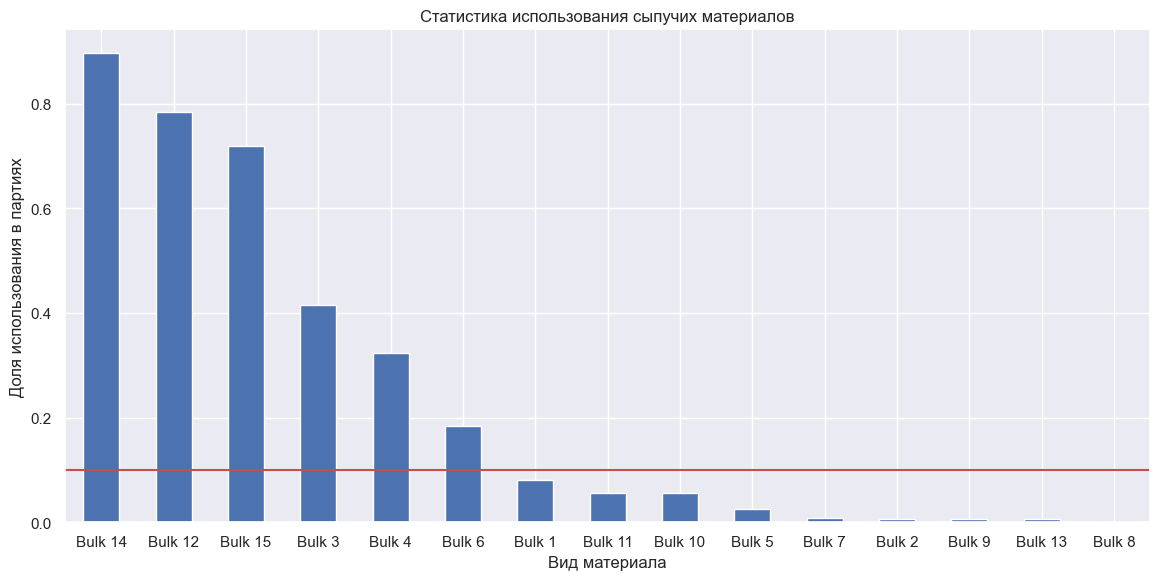

In [13]:
ax = (~bulk.isna()).drop('key', axis=1).mean().sort_values(ascending=False).plot(kind = 'bar', rot=0)
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Статистика использования сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Вид материала');

Тип данных в столбцах датасета 'Время' необходимо привести в тип datetime, пропуски в датасетах означают, что данный тип сыпучего материала не использовался в партии. Более чем в 10% партий использовались только материалы Bulk 14, Bulk 12, Bulk 15, Bulk 3, Bulk 4 и Bulk 6, также в материале Bulk 12 обнаружен выброс со значением 1849

### Данные о продувке сплава газом

In [14]:
data_info(gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


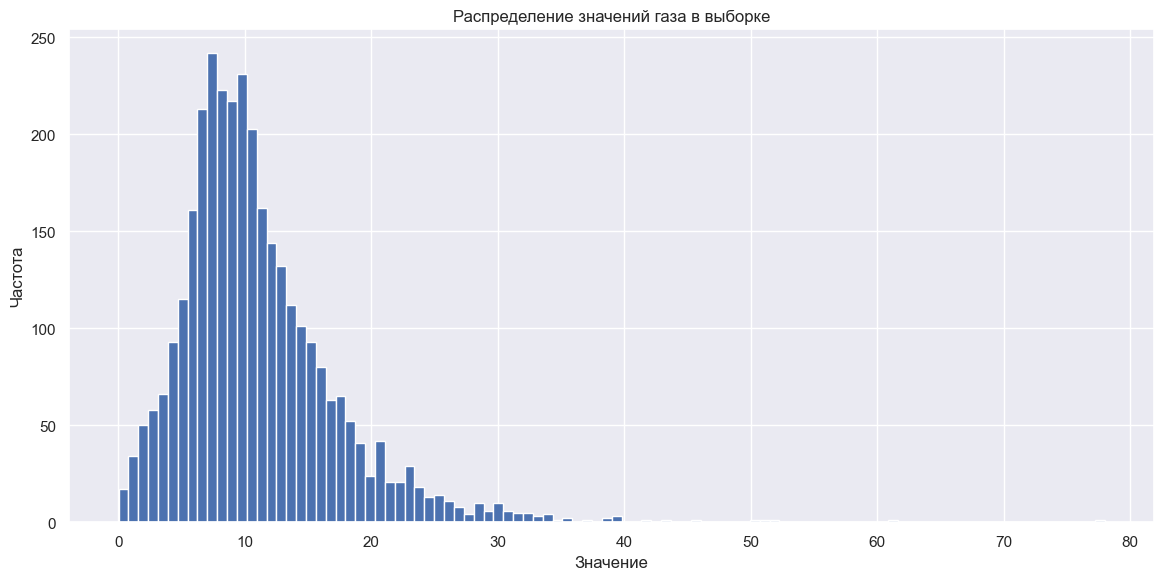

In [15]:
gas['Газ 1'].hist(bins=100)
plt.title('Распределение значений газа в выборке')
plt.xlabel('Значение')
plt.ylabel('Частота');


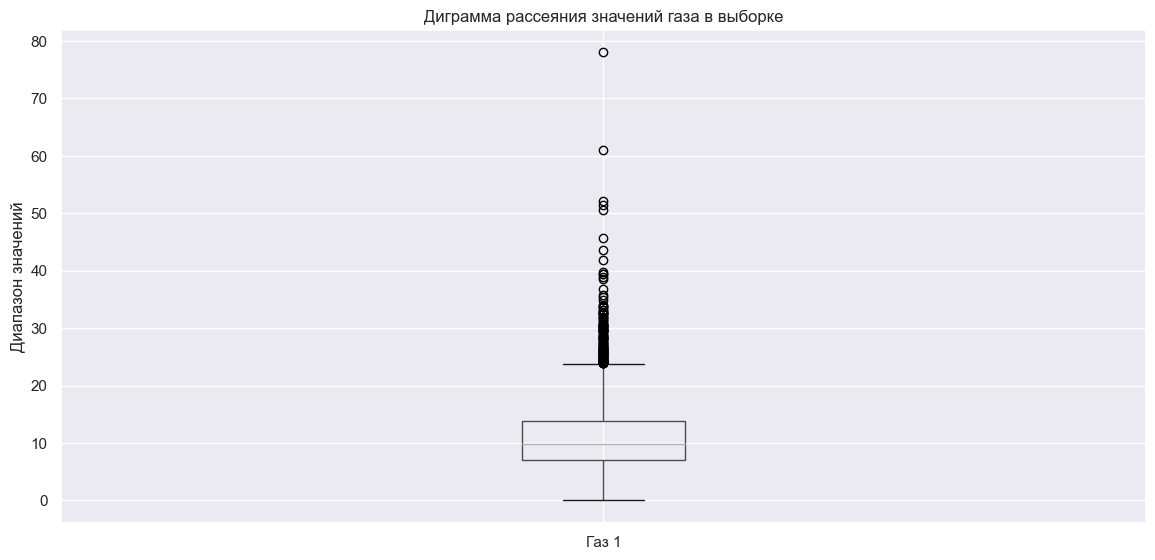

In [16]:
gas.boxplot(column='Газ 1')
plt.title('Диграмма рассеяния значений газа в выборке')
plt.ylabel('Диапазон значений');

Пропуски отсутствуют, тип данных соответствует значениям, распределение значений нормальное с положительным хвостом 

### Результаты измерения температуры

In [17]:
data_info(temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [18]:
print('Количество пропусков в столбце Температура:',
      round(temp['Температура'].isna().mean()*100,2),'%')

Количество пропусков в столбце Температура: 18.94 %


In [19]:
failed_keys = temp[temp['Температура'].isna()==True]['key'].unique()
print('Количество партий, в которых есть хотя бы один пропуск измерения температуры:',
      len(failed_keys),
      '\nВ отношении к количеству партий:',
      round(len(failed_keys)/len(temp['key'].unique())*100,2),'%')

Количество партий, в которых есть хотя бы один пропуск измерения температуры: 739 
В отношении к количеству партий: 22.98 %


In [20]:
no_temp_stat = pd.DataFrame()
for k in failed_keys:
    temp_key = temp.query('key == @k').reset_index(drop=True)[['Температура']]
    temp_key.columns = [k]
    no_temp_stat = no_temp_stat.append(temp_key.T)
pd.DataFrame(no_temp_stat.isna().sum(), columns=[['Количество пропусков']]).T


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Количество пропусков,0,739,739,739,739,739,739,739,739,739,739,739,739,739,739


*Во всех партиях с пропусками была измерена только начальная температура сплава*

Посмотрим на распределние начальных и конечных температур

In [21]:
start_temp = pd.DataFrame()
final_temp = pd.DataFrame()
for k in temp['key'].unique():
    start_temp = start_temp.append(temp.loc[(temp['key'] == k) & (temp['Время замера'] == temp.loc[temp['key']==k]['Время замера'].min())])
    final_temp = final_temp.append(temp.loc[(temp['key'] == k) & (temp['Время замера'] == temp.loc[temp['key']==k]['Время замера'].max())])

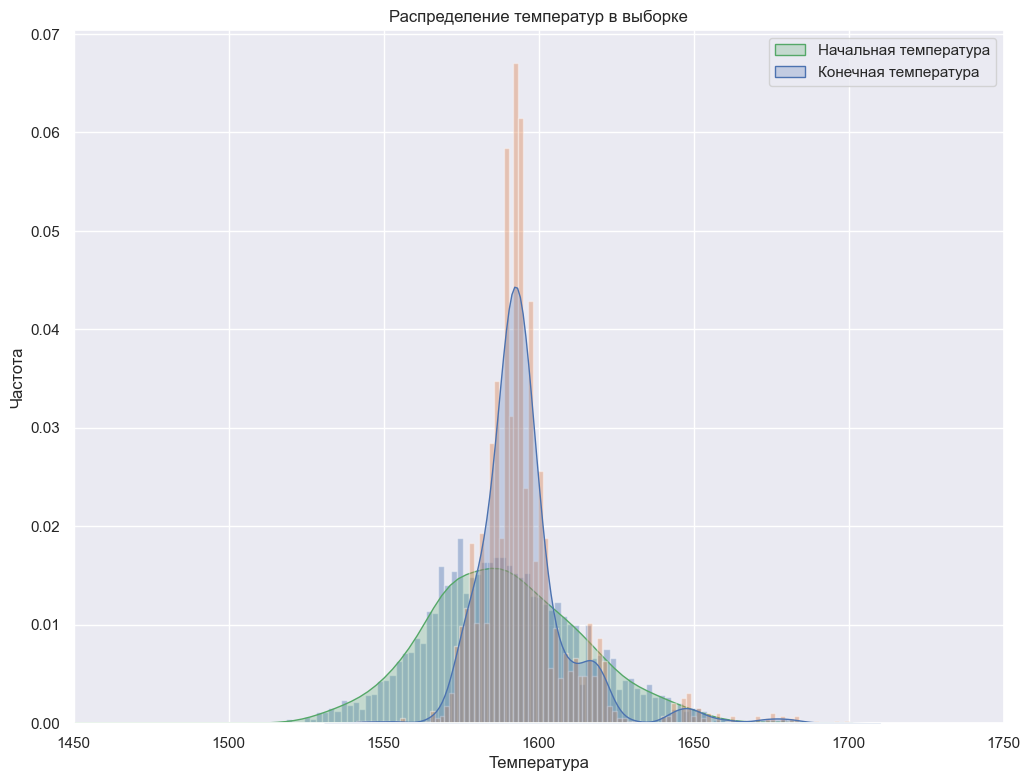

In [22]:
sns.set(rc={'figure.figsize':(12,9)})
sns.distplot(start_temp['Температура'], kde_kws={'shade':True, 'color':'g'}, bins=250)
sns.distplot(final_temp['Температура'], kde_kws={'shade':True, 'color':'b'}, bins=100)
plt.legend(['Начальная температура','Конечная температура'])
plt.title('Распределение температур в выборке')
plt.xlabel('Температура')
plt.xlim(1450,1750)
plt.ylabel('Частота');

График  начальной и конечной температур имеет нормальное распределение, в датасете выявлено 739 партий, в которых измерена только начальная температура сплава, что составляет почти 23% от всего количества партий. Также необходимо изменить тип данных в столбце Время замера

### Данные о проволочных материалах (объём, время)

In [23]:
print('_______________Объем_______________\n')
data_info(wire)
print('_______________Время_______________\n')
data_info(wire_time)

_______________Объем_______________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


_______________Время_______________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


По аналогии с данными о сыпучих материалах проверим, совпадают ли пропуски

In [24]:
pd.DataFrame((wire.isna() == wire_time.isna()).mean() == 1, columns=[['Полное совпадение пропусков']]).T

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
Полное совпадение пропусков,True,True,True,True,True,True,True,True,True,True


И построим график статистики использования проволоки и диаграмму рассеяния

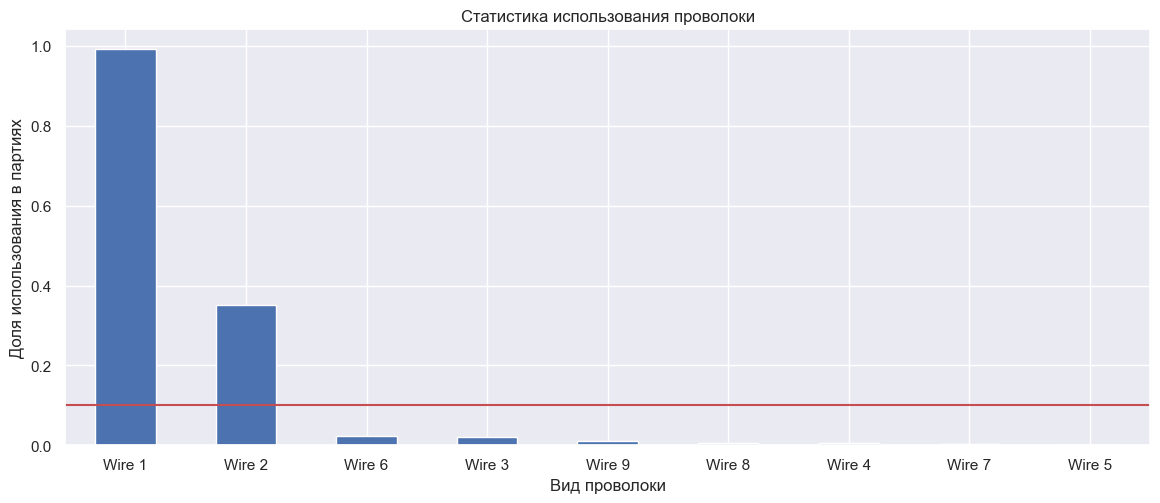

In [25]:
sns.set(rc={'figure.figsize':(14,5.4)})
ax = (~wire.isna()).drop('key', axis=1).mean().sort_values(ascending=False).plot(kind = 'bar', rot=0)
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Статистика использования проволоки')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Вид проволоки');

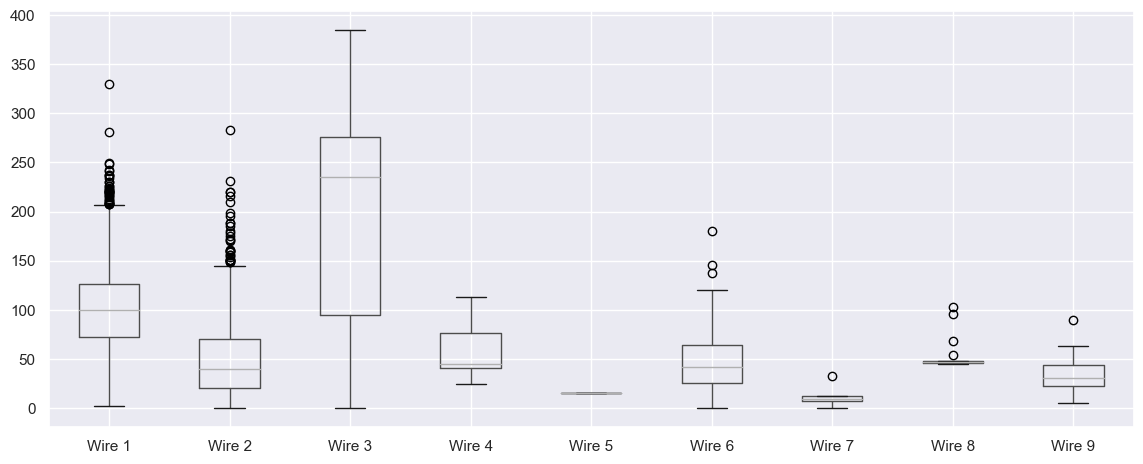

In [26]:
wire.drop('key', axis=1).boxplot();

Так же, как и в данных о сыпучих материалах, пропуски в данных о проволочных материалах означают, что материал не использовался в данной партии. Больше, чем в 10% партий используются только проволоки Wire 1 и Wire 2. В датасете 'Время' необходимо изменить тип данных на datetime

###  Этапы обработки

Выберем для понимания картины всех этапов обработки любую партию без пропусков в измерении температуры и выведем на экран данные из всех датасетов об этой партии

In [27]:
data_list = [arc,bulk,bulk_time,gas,temp,wire,wire_time]
for data in data_list:
    display(data.query('key == 867'))

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
4028,867,2019-06-06 08:03:49,2019-06-06 08:06:04,1.362161,0.948663
4029,867,2019-06-06 08:19:02,2019-06-06 08:21:37,0.520198,0.391826
4030,867,2019-06-06 08:22:48,2019-06-06 08:23:47,0.558775,0.361147
4031,867,2019-06-06 08:25:21,2019-06-06 08:27:11,0.525132,0.411021
4032,867,2019-06-06 08:29:59,2019-06-06 08:33:08,0.661064,0.578344
4033,867,2019-06-06 08:36:59,2019-06-06 08:41:13,0.365236,0.292677
4034,867,2019-06-06 08:43:12,2019-06-06 08:44:19,0.852855,0.620585


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
832,867,NaN,NaN,264.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,117.0,104.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
832,867,NaN,NaN,2019-06-06 08:44:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-06 08:41:30,NaN,2019-06-06 08:33:20,2019-06-06 08:27:26


,key,Газ 1
864,867,11.616807


,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
813,867,158.511604,35.07608,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
813,867,2019-06-06 08:24:06,2019-06-06 08:21:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Чтобы хронология была более понятна, объединим все данные в один датафрейм

In [28]:
def timeline(line):
    try:
        # Сыпучие материалы
        bulk_line = pd.concat([bulk.query('key == @line').drop('key',axis=1).T.dropna(),
                        bulk_time.query('key == @line').drop('key',axis=1).T.dropna()], axis=1)
        bulk_line['type'] = bulk_line.index
        bulk_line.columns = ['value','dt','type']
        bulk_line['dt'] = pd.to_datetime(bulk_line['dt'])
        bulk_line['process'] = 'Добавление сыпучих материалов'
        bulk_line = bulk_line.set_index('dt')
        bulk_line = bulk_line[['process','type','value']]

        # Проволочные материалы
        wire_line = pd.concat([wire.query('key == @line').drop('key',axis=1).T.dropna(),
                    wire_time.query('key == @line').drop('key',axis=1).T.dropna()], axis=1)
        wire_line['type'] = wire_line.index
        wire_line.columns = ['value','dt','type']
        wire_line['dt'] = pd.to_datetime(wire_line['dt'])
        wire_line['process'] = 'Добавление проволочных материалов'
        wire_line = wire_line.set_index('dt')
        wire_line = wire_line[['process','type','value']]

        # Нагрев электродами
        arc_line = arc.query('key == @line').set_index('Начало нагрева дугой')
        arc_line.index = pd.to_datetime(arc_line.index)
        arc_line['process'] = 'Нагрев дугой'

        # Газ (отсутствует временная метка)
        gas_line = gas.query('key == @line')
        gas_line.index = [np.NaN]
        gas_line['process'] = 'Продувка инертным газом'
        gas_line = gas_line.rename(columns={'Газ 1':'value'})

        # Измерение температуры
        temp_line = temp.query('key == @line').reset_index(drop=True)
        temp_line['Итерация'] = temp_line.index
        temp_line = temp_line.set_index('Время замера')
        temp_line.index = pd.to_datetime(temp_line.index)
        temp_line['process'] = 'Замер температуры'
        

        # Объединение в один датафрейм
        timeline_df = pd.concat([bulk_line,wire_line,arc_line,temp_line,gas_line]).sort_index()
        timeline_df[['key','Итерация']] = timeline_df[['key','Итерация']].bfill()
        timeline_df.columns = (['Наименование процесса', 'Тип материала','Количество материала'] 
                                + list(timeline_df.columns[3:]))

        return timeline_df
    except: pass

In [29]:
display(timeline(1))

,Наименование процесса,Тип материала,Количество материала,key,Конец нагрева дугой,Активная мощность,Реактивная мощность,Температура,Итерация
2019-05-03 11:02:04,Замер температуры,NaN,NaN,1.0,NaN,NaN,NaN,1571.0,0.0
2019-05-03 11:02:14,Нагрев дугой,NaN,NaN,1.0,2019-05-03 11:06:02,0.305130,0.211253,NaN,1.0
2019-05-03 11:06:19,Добавление проволочных материалов,Wire 1,60.059998,1.0,NaN,NaN,NaN,NaN,1.0
2019-05-03 11:07:18,Замер температуры,NaN,NaN,1.0,NaN,NaN,NaN,1604.0,1.0
2019-05-03 11:07:28,Нагрев дугой,NaN,NaN,1.0,2019-05-03 11:10:33,0.765658,0.477438,NaN,2.0
2019-05-03 11:10:43,Добавление сыпучих материалов,Bulk 15,154.000000,1.0,NaN,NaN,NaN,NaN,2.0
2019-05-03 11:11:34,Замер температуры,NaN,NaN,1.0,NaN,NaN,NaN,1618.0,2.0
2019-05-03 11:11:44,Нагрев дугой,NaN,NaN,1.0,2019-05-03 11:14:36,0.580313,0.430460,NaN,3.0
2019-05-03 11:14:50,Добавление сыпучих материалов,Bulk 14,150.000000,1.0,NaN,NaN,NaN,NaN,3.0
2019-05-03 11:18:04,Замер температуры,NaN,NaN,1.0,NaN,NaN,NaN,1601.0,3.0


И сделаем тоже самое для партии с пропущенными значениями в измерении температуры

In [30]:
display(timeline(failed_keys[1]))

,Наименование процесса,Тип материала,Количество материала,key,Конец нагрева дугой,Активная мощность,Реактивная мощность,Температура,Итерация
2019-08-10 14:41:14,Замер температуры,NaN,NaN,2501.0,NaN,NaN,NaN,1587.0,0.0
2019-08-10 14:41:24,Нагрев дугой,NaN,NaN,2501.0,2019-08-10 14:44:30,0.464181,0.412794,NaN,1.0
2019-08-10 14:44:43,Добавление проволочных материалов,Wire 3,254.462219,2501.0,NaN,NaN,NaN,NaN,1.0
2019-08-10 14:49:15,Замер температуры,NaN,NaN,2501.0,NaN,NaN,NaN,NaN,1.0
2019-08-10 14:49:25,Нагрев дугой,NaN,NaN,2501.0,2019-08-10 14:52:26,1.062246,0.779261,NaN,2.0
2019-08-10 14:52:40,Добавление проволочных материалов,Wire 2,198.452789,2501.0,NaN,NaN,NaN,NaN,2.0
2019-08-10 15:02:56,Замер температуры,NaN,NaN,2501.0,NaN,NaN,NaN,NaN,2.0
2019-08-10 15:03:06,Нагрев дугой,NaN,NaN,2501.0,2019-08-10 15:06:53,0.799712,0.629432,NaN,3.0
2019-08-10 15:07:05,Добавление сыпучих материалов,Bulk 3,255.000000,2501.0,NaN,NaN,NaN,NaN,3.0
2019-08-10 15:07:05,Добавление проволочных материалов,Wire 1,172.754410,2501.0,NaN,NaN,NaN,NaN,3.0


*Видно, что партия с пропусками проходит все те же этапы, что и обычно, поэтому пропуски не являются результатом рабочего процесса в данном случае и могут быть вызваны, например, сбоем в работе оборудования*

***В представленных данных было обнаружено сравнительно небольшое количество аномалий в разных таблицах и довольно большое количество партий с только одним измерением температуры - все эти партии необходимо будет удалить, так как они не подойдут для обучения моделей. В таблицах с данными о подаче сыпучих и проволочных материалов пропуски означают отсутствие материала в партии, их можно будет заменить на другие значения (например, 0) и оставить в исследовании.***

## Предобработка данных

### Обработка пропусков и аномалий

Для начала избавимся от явных аномалий в данных - это отрицательное значение реактивной мощности и чрезмерно малые температуры в замерах (менее 1400 градусов). Также, у сыпучаго материала Bulk 12 максимальное значение уж слишком сильно выбивается из тренда, считаю, что этот выброс тоже можно удалить

In [31]:
temp = temp.query('Температура > 1400')
arc = arc[arc['Реактивная мощность'] > 0]
bulk = bulk[bulk['Bulk 12'] != bulk['Bulk 12'].max()]

Судя по всему, в нашей выборке есть типы материалов, которые не используются вовсе. Выясним, что это за материалы и удалим их

In [32]:
pd.DataFrame(pd.concat([bulk.drop('key',axis=1).isna().all(), wire.drop('key',axis=1).isna().all()]))

,0
Bulk 1,False
Bulk 2,False
Bulk 3,False
Bulk 4,False
Bulk 5,False
Bulk 6,False
Bulk 7,False
Bulk 8,False
Bulk 9,False
Bulk 10,False


*Все материалы присутствуют, даже в небольших количествах, в исследовании*

Удалим также партии, в которых измерена только начальная температура. Их номера мы ранее сохранили в переменной failed_keys

In [33]:
temp = temp.query('key not in @failed_keys')
len(temp['key'].unique())

2477

*В наших данных осталось 2477 партий с измеренной температурой*

Проверим, есть ли партии, в которые не добавляется ни одного легирующего материала

In [34]:
bulk[bulk.drop('key',axis=1).isna().all(1)]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15


In [35]:
wire[wire.drop('key',axis=1).isna().all(1)]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9


*Таких партий нет*

### Выбор признаков

Напишем функцию для объединения данных по партиям без учета хронологии. Для этого создадим новые столбцы:
- total_power - будет содержать в себе суммарную общую мощность по всем итерациям ковша, которая вычисляется по формуле ![jupyter](https://wikimedia.org/api/rest_v1/media/math/render/svg/ee76c81777b87da8d701e8b5ff895a512414cd05), где $P$ - активная мощность, $Q$ - реактивная мощность;
- heat_time - суммарное время всех итераций нагрева дугой для ковша в секундах;
- start_temp - нулевой замер температуры сплава - до добавления легирующих материалов;
- final_temp - финальная температура сплава - наш целевой признак.

In [36]:
def merging(line):
    # Сыпучие материалы (заменяем пропущенные значения не добавленных в сплав материалов на 0)
    bulk_line = bulk.query('key == @line').fillna(0)
    bulk_line = bulk_line.reset_index(drop=True).astype(int).set_index('key')

    # Проволочные материалы (по аналогии с сыпучими материалами)
    wire_line = wire.query('key == @line').fillna(0)
    wire_line = wire_line.reset_index(drop=True).astype(int).set_index('key')

    # Нагрев электродами
    arc_line = arc.query('key == @line')
    arc_line['heat_time'] = ((pd.to_datetime(arc_line['Конец нагрева дугой']) - 
                              pd.to_datetime(arc_line['Начало нагрева дугой']))
                             .dt.total_seconds().astype(int))
    arc_line['total_power'] = (arc_line['Активная мощность']**2 + 
                               arc_line['Реактивная мощность']**2)**0.5
    arc_line = arc_line.groupby(by='key')[['heat_time', 'total_power']].sum()

    # Продувка инертным газом
    gas_line = gas.query('key == @line')
    gas_line = gas_line.rename(columns={'Газ 1':'gas'}).set_index('key')

    # Замеры температуры
    temp_line = temp.query('key == @line').set_index('key')
    temp_line['start_temp'] = temp_line[temp_line['Время замера'] == temp_line['Время замера']
                                        .min()]['Температура']
    temp_line['final_temp'] = temp_line[temp_line['Время замера'] == temp_line['Время замера']
                                        .max()]['Температура']
    temp_line = temp_line.drop(['Время замера','Температура'], axis=1).drop_duplicates()

    # Объединение таблиц - в итоговой таблице останутся только строки, 
    # в которых по номеру ковша нет пропусков во всех таблицах
    df = pd.concat([bulk_line,wire_line,gas_line, arc_line,temp_line], axis=1).dropna()
    return df

In [37]:
df = pd.DataFrame()
for i in temp['key'].unique():
    df = df.append(merging(i))
df

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,...,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,gas,heat_time,total_power,start_temp,final_temp
key,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29.749986,1098.0,3.718736,1571.0,1613.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.555561,811.0,2.588349,1581.0,1602.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,28.554793,655.0,5.019223,1596.0,1599.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,18.841219,741.0,3.400038,1601.0,1625.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.413692,869.0,2.816980,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,0.0,7.125735,723.0,3.868721,1570.0,1591.0
2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,...,0.0,0.0,0.0,0.0,0.0,9.412616,940.0,5.070316,1554.0,1591.0
2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.271699,569.0,4.360918,1571.0,1589.0


*В таблице осталось 2328 партий - значительно меньше чем в исходных данных, зато эти данные предобработаны и модели будут эффективнее обучаться на них. Будем надеяться, что этого хватит для достижения нужного значения целевой метрики*

Проверим признаки на мультиколлинеарность - избавимся от признаков, коррелирующих более чем на 90%

interval columns not set, guessing: ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9', 'gas', 'heat_time', 'total_power', 'start_temp', 'final_temp']


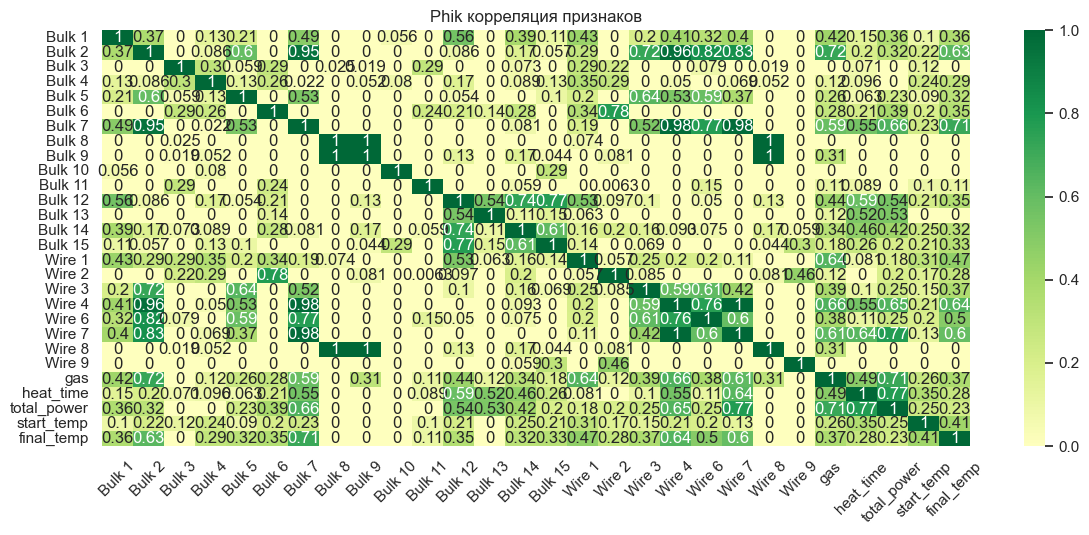

In [38]:
def heatmap(corr):
    sns.heatmap(corr, 
                xticklabels=corr.columns, 
                yticklabels=corr.columns, 
                cmap='RdYlGn', center=0, annot=True)

    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

phik_overview = (df.phik_matrix()
                )


heatmap(phik_overview)
plt.title('Phik корреляция признаков')
plt.show()

*Столбцы Wire 8 , Bulk 8 и Bulk 9, имеют стопроцентную корреляцию между собой, можно избавиться от двух из них. Столбцы Wire 4 и Wire 7 также можно удалить, так как они, помимо корреляции между собой, имеют высокую корреляцию и с другими признаками, и столбец Bulk 2, он также имеет проблему мультиколлинеарности с несколькими признаками. Высокий уровень корреляции у столбцов heat_time и total_power, но он меньше установленного порога в 90%, поэтому оставим оба признака*

In [39]:
df = df.drop(['Bulk 2', 'Bulk 8', 'Bulk 9', 'Wire 4', 'Wire 7'], axis=1)

***Проведена предобработка данных: избавились от пропусков, аномалий, неиспользуемых и коррелирующих между собой материалов. Также избавились от партий, в которых была измерена только начальная температура сплава. Наш финальный датасет выглядит следующим образом 2328 строк - партий, 24 столбца, среди которых столбцы с наименованием Bulk # и Wire # - сыпучие материалы, при их отсутствии в ковше принимает значение 0, gas - величина инертного газа для продувки сплава, - total_power - суммарная общая мощность по всем итерациям ковша, heat_time - суммарное время всех итераций нагрева дугой для ковша в секундах, start_temp - нулевой замер температуры сплава - до добавления легирующих материалов, final_temp - финальная температура сплава - наш целевой признак.***

## Машинное обучение

Разделим наш итоговый датасет на обучающую и тестовую выборки в отношении 3:1. Исследуем 3 модели: линейная регрессия, LightGBM и CatBoost, сравним их качество на кросс-валидации, для перебора гиперпараметров последних двух моделей используем библиотеку Optuna

In [40]:
train, test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

features_train = train.drop(['final_temp'], axis=1)
target_train = train['final_temp']

features_test = test.drop(['final_temp'], axis=1)
target_test = test['final_temp']

print('Размеры получившихся выборок: ',
      '\nОбучающая:', features_train.shape, target_train.shape,
      '\nТестовая:', features_test.shape, target_test.shape)

Размеры получившихся выборок:  
Обучающая: (1746, 23) (1746,) 
Тестовая: (582, 23) (582,)


### Линейная регрессия

In [41]:
scaler = StandardScaler()
features_train_lr = scaler.fit_transform(features_train)
features_test_lr = scaler.transform(features_test)

In [42]:
lr = LinearRegression()
nmae = cross_val_score(lr, features_train_lr, target_train,
                             scoring='neg_mean_absolute_error', cv=8)

In [43]:
stats = pd.DataFrame(round(nmae.mean()*(-1),2),
                     columns=[['Линейная регрессия']], 
                     index=[['MAE']])
stats

,Линейная регрессия
MAE,6.21


### LightGBM

In [44]:
def objective(trial):
    
    param = {
    'random_state': RANDOM_STATE,
    'metric': 'mae', 
    'n_estimators': trial.suggest_int('n_estimators', 10, 2000, 40),
    'learning_rate': trial.suggest_discrete_uniform('learning_rate', 0.001, 0.12, 0.002),
    'max_depth': trial.suggest_int('max_depth', 1, 150, 4),
    }
    
    model = LGBMRegressor(**param)  
    nmae = cross_val_score(model, features_train, target_train,
                             scoring="neg_mean_absolute_error", cv=8)
    return round(nmae.mean()*(-1),2)

In [45]:
lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(objective, n_trials=30)
lgb_best_params = lgb_study.best_trial.params

[I 2023-06-04 14:48:35,908] A new study created in memory with name: no-name-3e7206d2-a560-4a09-b8db-d069e1139a9d
[I 2023-06-04 14:48:56,327] Trial 0 finished with value: 6.64 and parameters: {'n_estimators': 970, 'learning_rate': 0.039, 'max_depth': 141}. Best is trial 0 with value: 6.64.
[I 2023-06-04 14:49:18,229] Trial 1 finished with value: 6.7 and parameters: {'n_estimators': 1050, 'learning_rate': 0.07100000000000001, 'max_depth': 145}. Best is trial 0 with value: 6.64.
[I 2023-06-04 14:49:30,578] Trial 2 finished with value: 6.75 and parameters: {'n_estimators': 610, 'learning_rate': 0.115, 'max_depth': 69}. Best is trial 0 with value: 6.64.
[I 2023-06-04 14:50:06,464] Trial 3 finished with value: 6.7 and parameters: {'n_estimators': 1850, 'learning_rate': 0.113, 'max_depth': 17}. Best is trial 0 with value: 6.64.
[I 2023-06-04 14:50:44,896] Trial 4 finished with value: 6.75 and parameters: {'n_estimators': 1930, 'learning_rate': 0.07300000000000001, 'max_depth': 77}. Best is t

In [46]:
stats['LightGBM'] = lgb_study.best_value
stats

,Линейная регрессия,LightGBM
MAE,6.21,6.24


### CatBoost

In [47]:
def objective(trial):
    
    param = {
    'random_state': RANDOM_STATE,
    'eval_metric':'MAE',
    'iterations':trial.suggest_int('iterations', 5, 1000, 10),
    'learning_rate': trial.suggest_discrete_uniform('learning_rate', 0.01, 0.15, 0.002),
    'max_depth': trial.suggest_int('max_depth', 1, 15),
    'verbose':False,
    }
    
    model = CatBoostRegressor(**param)    
    nmae = cross_val_score(model, features_train, target_train,
                             scoring='neg_mean_absolute_error', cv=8)
    return round(nmae.mean()*(-1),2)

In [48]:
cat_study = optuna.create_study(direction='minimize')
cat_study.optimize(objective, n_trials=30)
cat_best_params = cat_study.best_trial.params

[I 2023-06-04 14:57:35,237] A new study created in memory with name: no-name-f6d3ea9a-509c-478a-8583-3ea088f9c600
[I 2023-06-04 15:06:35,636] Trial 0 finished with value: 6.54 and parameters: {'iterations': 785, 'learning_rate': 0.08399999999999999, 'max_depth': 14}. Best is trial 0 with value: 6.54.
[I 2023-06-04 15:06:36,534] Trial 1 finished with value: 6.07 and parameters: {'iterations': 355, 'learning_rate': 0.092, 'max_depth': 3}. Best is trial 1 with value: 6.07.
[I 2023-06-04 15:06:37,436] Trial 2 finished with value: 6.19 and parameters: {'iterations': 485, 'learning_rate': 0.14800000000000002, 'max_depth': 2}. Best is trial 1 with value: 6.07.
[I 2023-06-04 15:06:41,187] Trial 3 finished with value: 6.09 and parameters: {'iterations': 575, 'learning_rate': 0.028000000000000004, 'max_depth': 6}. Best is trial 1 with value: 6.07.
[I 2023-06-04 15:06:42,360] Trial 4 finished with value: 6.1 and parameters: {'iterations': 475, 'learning_rate': 0.068, 'max_depth': 3}. Best is tria

In [49]:
stats['CatBoost'] = cat_study.best_value
stats

,Линейная регрессия,LightGBM,CatBoost
MAE,6.21,6.24,6.07


***Наименьшее значение метрики MAE показала модель CatBoost. Выберем ее в качестве основной***

## Тестирование выбранной модели

In [50]:
cat = CatBoostRegressor(**cat_best_params, verbose=False)
cat.fit(features_train, target_train)
cat_preds = pd.Series(cat.predict(features_test), index=target_test.index)
mae = mean_absolute_error(target_test, cat_preds)
stats['CatBoost Test'] = round(mae,2)
stats

,Линейная регрессия,LightGBM,CatBoost,CatBoost Test
MAE,6.21,6.24,6.07,6.24


Построим график важности признаков для итоговой модели

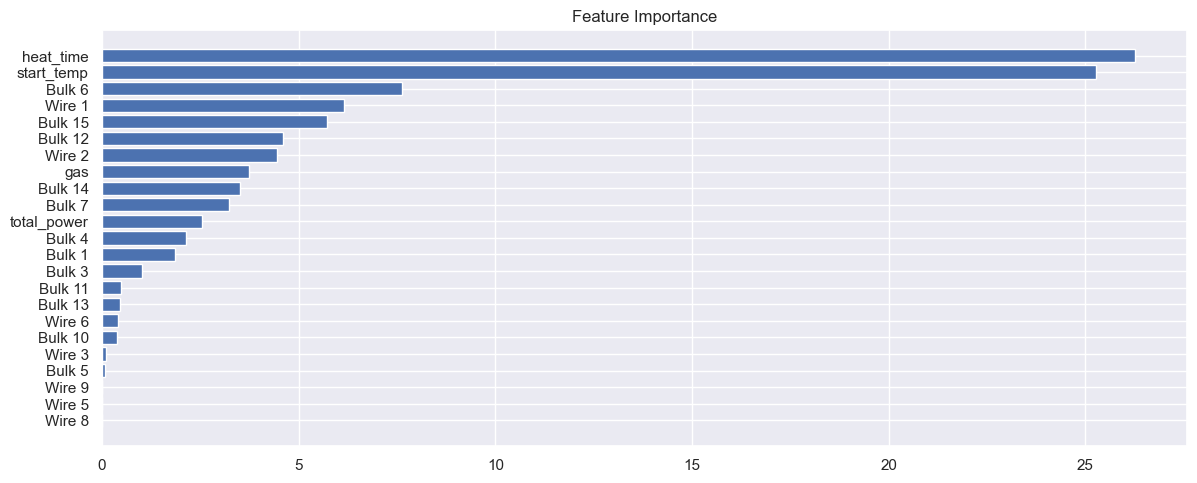

In [51]:
feature_importance = cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance');


Самым важными признаками ожидаемо оказались время нагрева heat_time и начальная температура start_temp

### Сравнение с константной моделью

Сравним выбранную нами модель с константной Dummy - моделью

In [52]:
dummy = DummyRegressor()
nmae = cross_val_score(dummy, features_test_lr, target_test,
                             scoring='neg_mean_absolute_error', cv=10)
stats['Dummy Regressor'] = round(nmae.mean()*(-1),2)
stats

,Линейная регрессия,LightGBM,CatBoost,CatBoost Test,Dummy Regressor
MAE,6.21,6.24,6.07,6.24,8.33


***Выбранная нами модель CatBoost показала на тестовой выборке значение MAE, удовлетворяющее условию MAE<6.8, а также прошла проверку на адекватность в сравнении с константной Dummy - моделью. Итоговое значение MAE на тестовой выборке равно 6.24, т.е. модель предсказывает температуру сплава с погрешностью ±6.24 градуса.***

## Отчет о проделанной работе

***
***Целью нашего исследования было построение модели для предсказания температуры стали как одного из этапов уменьшения потребления электроэнергии на этапе обработки стали. В нашем распоряжении были данные об электродах, данные о подаче сыпучих материалов (объём и время), данные о продувке сплава газом, результаты измерения температуры, данные о проволочных материалах (объём и время).*** 

***В ходе первичного анализа данных были выявлены небольшое количество аномалий в данных, которые были удалены, а также было выявлено большое количество партий с измерением только первичной температуры сплава. После консультаций с заказчиком было решено не учитывать данные партии в исследовании, как вероятный сбой оборудования для замера температуры.***

***Одним из ключевых моментов было объединение оставшихся в нашем распоряжении данных в единую структуру по принципу `1 партия - 1 строка`. Для этого было решено не учитывать в дальнейшем исследовании замеры температур, кроме первого и последного замера каждой партии, а также была произведена замена активной и реактивной мощностей на общую мощность, рассчитанную по формуле. Общая мощность и время нагрева сплава электродами были суммированы по итерациям для каждой партии и также включены в структуру. Далее была проведена проверка на мультиколлинеарность в итоговой таблице, которая выявила корреляцию у нескольких признаков, от которых было решено избавиться.***

***На этапе машинного обучения было произведено сравнение 3 моделей на кросс-валидации: линейная регрессия и 2 модели градиентного бустинга: LightGBM и CatBoost. Ключевой метрикой была выбрана cредняя абсолютная ошибка (MAE). Все 3 модели показали удовлетворительные результаты, в качестве основной была выбрана модель CatBoost. Выбранная модель была протестирована на тестовых данных, MAE составило `6.24`, что так же удовлетворяет условию заказчика (MAE<6.8), а также прошла проверку на адекватность в сравнении с константной моделью. Самыми важными признаками для модели оказались время нагрева электродами и начальная температура сплава.***

**Список признаков, использованных для обучения лучшей модели:**
- start_temp - начальная температура сплава (до добавления легирующих материалов)
- heat_time - общее время нагрева сплава электродами
- total_power - общая мощность
- gas - величина инертного газа, затраченная на продувку сплава
- Bulk 1, Bulk 3, Bulk 4, Bulk 5, Bulk 6, Bulk 7, Bulk 10, Bulk 11, Bulk 12, Bulk 13, Bulk 14, Bulk 15 - количество добавленных сыпучих материалов
- Wire 1, Wire 2, Wire 3, Wire 5, Wire 6, Wire 8, Wire 9 - количество добавленных проволочных материалов
- final_temp - финальная температура сплава - ключевая метрика

**Список гиперпараметров лучшей модели:**
- random_state : 22052023
- iterations : 585
- learning_rate : 0.03
- max_depth : 6

***Для улучшения модели можно посоветовать произвести обучение на большем наборе данных. Что же касается цели экономии энергоресурсов в целом, можно постараться уменьшить разброс в измерениях, в нашем случае температуры©. Также можно попробовать уменьшить значение реактивной мощности путем установки компенсирующих устройств, если таких еще нет на предприятии.***
***
